# 4 Mel Frequency Cepstrum Coefficients step-by-step

All tests OK
<class 'numpy.ndarray'>


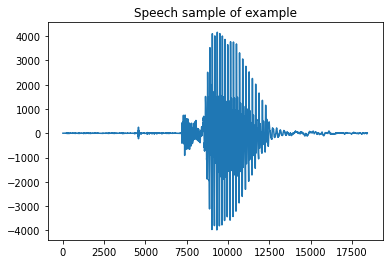

In [94]:
#Koray Amico Kulbay, DT2119, Lab1
import lab1_proto as proto
import lab1_tools as tools
import numpy as np
import matplotlib.pyplot as plt
from test import tests
from sklearn.mixture import GaussianMixture
import pandas as pd
from plotnine import *
%matplotlib inline
from scipy.cluster.hierarchy import linkage, dendrogram

from numpy import asarray, savetxt, loadtxt


tests()
example = np.load('lab1_example.npz', allow_pickle=True)['example'].item()
data = np.load('lab1_data.npz', allow_pickle=True)['data']
#data is an ndarray where each element is a dictionary 
print(type(data[0]["samples"]))

#Getting familiar with the set up
plt.plot(range(1,len(example["samples"])+1),example["samples"])
plt.title("Speech sample of example")
plt.show()



## 4.1 Enframe

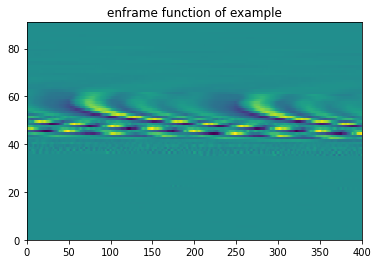

In [95]:
fsampling = 20E3 #Hz
winlen = int(20E-3*fsampling)
winshift = int(10E-3*fsampling)
examplesignal = example["samples"]
examplesignal = proto.enframe(examplesignal,winlen,winshift)
plt.pcolormesh(examplesignal)
plt.title("enframe function of example")
plt.show()

## 4.2 Pre-emphasis
Linear filter in general: $y[n] = \frac{1}{a_0}(\sum_{i=0}^Pb_ix[n-i] - \sum_{j=1}^Q a_jy[n-j])$

We want $y[n] = x[n] - \alpha x[n] $. 

Choose: P=1, Q=NaN, $b_0$=1, $b_1$=$- \alpha$ = -0.97, $a_0$=1

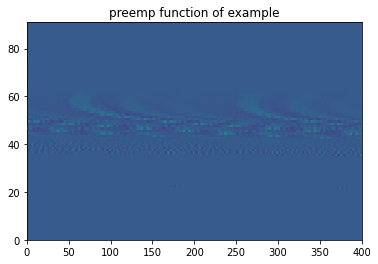

In [96]:
examplesignal = proto.preemp(examplesignal)
plt.pcolormesh(examplesignal)
plt.title("preemp function of example")
plt.show()

## 4.3 Hamming Window

This is needed to avoid sidelobes in fourier transform. Lose a bir of resolution, but better to lose that than having interference. 

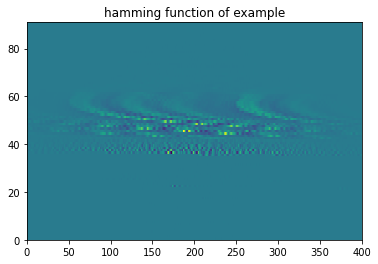

In [97]:
examplesignal = proto.windowing(examplesignal)
plt.pcolormesh(examplesignal)
plt.title("hamming function of example")
plt.show()

## 4.4 Fast Fourier Transform

$f_{max} = f_{sample}/2$ = 10 kHz

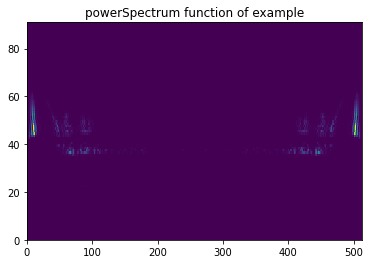

In [98]:
examplesignal = proto.powerSpectrum(examplesignal,512)
plt.pcolormesh(examplesignal)
plt.title("powerSpectrum function of example")
plt.show()

## 4.5 Mel filterbank log spectrum

The filter for the higher frequencies consists of "wider" triangles with larger relative spacing. This results in a lower resolution for high frequencies. This translated well into natural hearing of humans. 

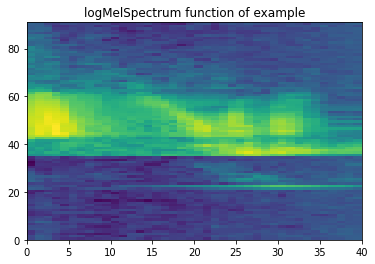

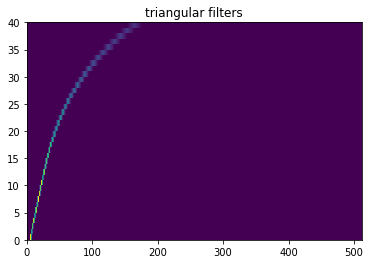

In [99]:
examplesignal,trfil = proto.logMelSpectrum(examplesignal,fsampling)
plt.pcolormesh(examplesignal)
plt.title("logMelSpectrum function of example")
plt.show()

plt.pcolormesh(trfil)
plt.title("triangular filters")
plt.show()

## 4.6 Cosine transform and Liftering

The expression for the coefficients is: 
$C_j = \sqrt{\frac{2}{N}} \sum_{i=1}^N A_i \cos(\frac{j \pi (i-0.5)}{N})$

We can see that each coefficient is affected by the size of N. This means that choosing a specific value for $N_p$ rather than truncating the desired coefficients from after using $N_q$, where $q>p$ $\Rightarrow \bar{C}_p \neq \bar{C}_q$. This can also be explained that when using different total number of coefficients a coeffiecent $C_i$ covers the amplitude of different "frequency spans".



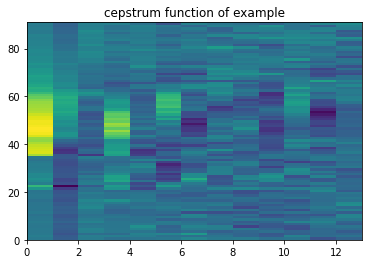

In [100]:
examplesignal = proto.cepstrum(examplesignal,13)
plt.pcolormesh(examplesignal)
plt.title("cepstrum function of example")
plt.show()

if not ((examplesignal-example['lmfcc']).max() < 1e-7).all():
    raise Exception("cepstrum doesn't work")

## Plotting coefficients of the main data


In [101]:
#plotting all speech samples
# for i in range(len(data)):
#     plt.pcolormesh(proto.mfcc(data[i]["samples"]))
#     plt.show()



# 5 Feature Correlation


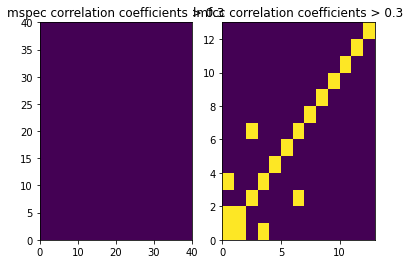

In [102]:
#Add processed information of each data point in data 

for i in range(len(data)):
    datapt = data[i]
    fsampling = datapt["samplingrate"]
    winlen = int(20E-3*fsampling)
    winshift = int(10E-3*fsampling)
    datapt["enframed"] = proto.enframe(datapt["samples"],winlen,winshift)
    datapt["preemp"] = proto.preemp(datapt["enframed"])
    datapt["windowing"] = proto.windowing(datapt["preemp"])
    datapt["powerSpectrum"] = proto.powerSpectrum(datapt["windowing"],512)
    datapt["mspec"] = proto.logMelSpectrum(datapt["powerSpectrum"],fsampling)[0]
    datapt["lmfcc"] = proto.cepstrum(datapt["mspec"],13)
    
# Create large concatinated Matrices for mpspec and lmfcc
Mmspec = np.concatenate([dp["mspec"] for dp in data])
Mlmfcc = np.concatenate([dp["lmfcc"] for dp in data])

# Create correleation coefficient matrix between all features for each feature type
corr_coef_mspec = np.corrcoef(Mmspec.T) #!! Transpose since np.corrcoef syntax has: each row is a variable; each column is a single observation. 
corr_coef_lmfcc = np.corrcoef(Mlmfcc.T)
fig, axs = plt.subplots(1,2)
axs[0].pcolormesh(corr_coef_mspec > 0.3) #sets all values < 0.3 = 0. #Pearson Corr coeff < 0.3 is regarded to be of small correlation: https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide.php#:~:text=The%20Pearson%20product%2Dmoment%20correlation,and%20is%20denoted%20by%20r.
axs[0].set_title("mspec correlation coefficients > 0.3")
axs[1].pcolormesh(corr_coef_lmfcc > 0.3)
axs[1].set_title("lmfcc correlation coefficients > 0.3")

plt.show()

One can clearly see the stronger linear correlation for the liftered mfccs's on the right plot above compared to the uliftered ones to the left. Since the data shows a linear behaviour the assumption of a diagonal covariance matrix holds.

# 6 Explore Speech Segments with Clustering

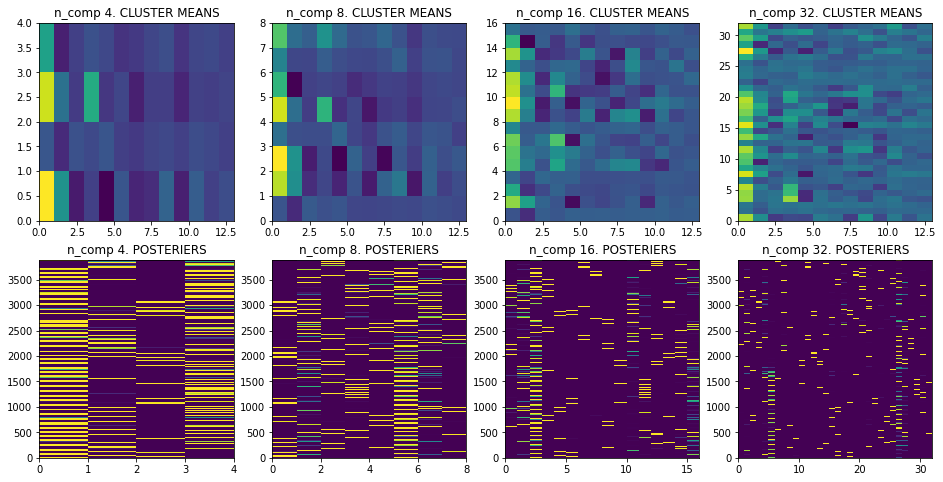

In [88]:
fig, axs = plt.subplots(2,4,figsize=(16, 8))
components_list = [4, 8, 16, 32]

for i, components in enumerate(components_list):
    GMM = GaussianMixture(n_components=components)
    gmm_plot_means = GMM.fit(Mlmfcc).means_
    gmm_plot_posts = GMM.fit(Mlmfcc).predict_proba(Mlmfcc)
    axs[0][i].pcolormesh(gmm_plot_means)
    axs[1][i].pcolormesh(gmm_plot_posts)
    axs[0][i].set_title("n_comp {}. CLUSTER MEANS".format(str(components)))
    axs[1][i].set_title("n_comp {}. POSTERIERS".format(str(components)))

plt.show()


#plot = GMM.fit(Mlmfcc).means_
#print(GMM.fit(Mlmfcc).means_)

#plt.pcolormesh(GMM.fit(Mlmfcc).means_)
#plt.show()


^^ ROW1: cluster id vs features (MFCC), colorplot is mean value for cluster location.

^^ROW2: observation instance (concatinated windows of all 44 samples) vs cluster id, colorplot is probability of observation to be assigned to cluster_col

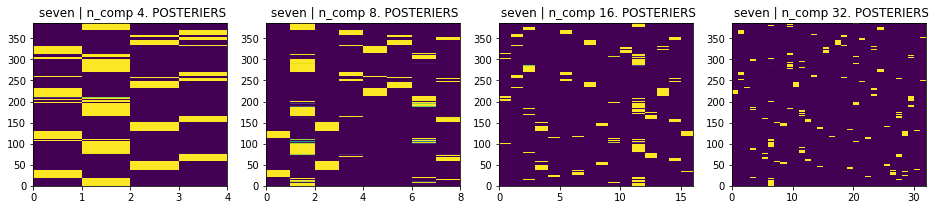

In [89]:
id_seven = [16, 17, 38, 39]

#check
Mlmfcc_7 = []
for id in id_seven:
    if data[id]["digit"] != "7": 
        raise Exception("not comparing all 7's!")
    Mlmfcc_7.append(data[id]["lmfcc"])
Mlmfcc_7 = np.concatenate(Mlmfcc_7)

fig, axs = plt.subplots(1,4,figsize=(16, 3))

for i, components in enumerate(components_list):
    GMM = GaussianMixture(n_components=components)
    gmm_plot_posts = GMM.fit(Mlmfcc_7).predict_proba(Mlmfcc_7)
    axs[i].pcolormesh(gmm_plot_posts)
    axs[i].set_title(" seven | n_comp {}. POSTERIERS".format(str(components)))

plt.show()


    


^^ concatinated windows for all 4 instances of "seven" vs cluster id. colorplot is probability of observation/window to be assigned to cluster_col

We now continue to compare the posterior plot of a man and woman

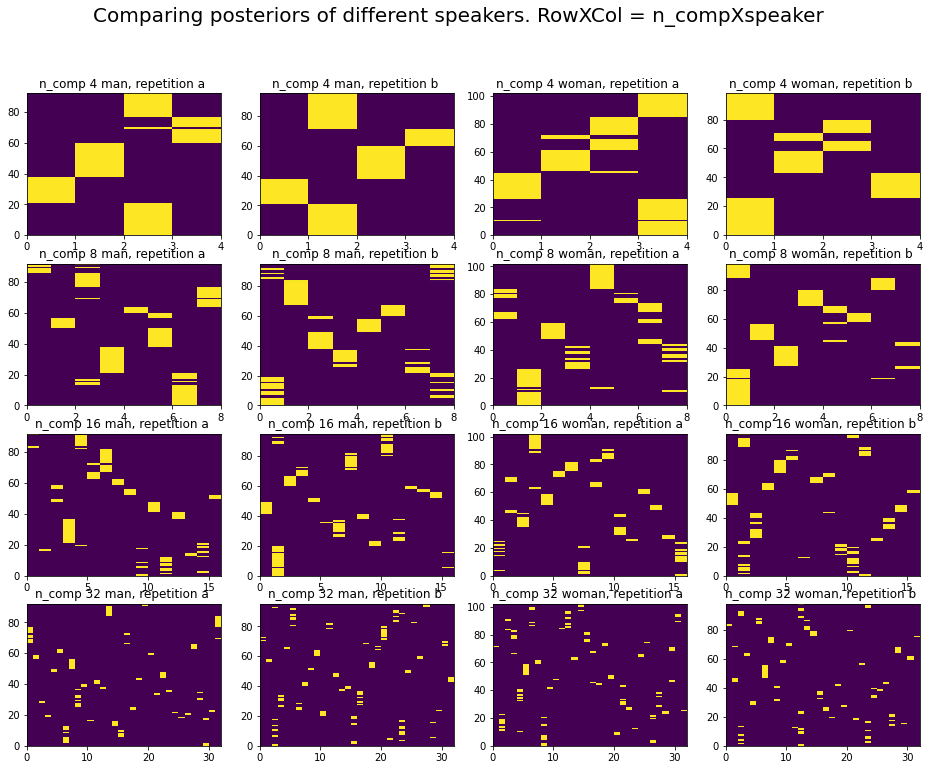

In [90]:

fig, axs = plt.subplots(4,4,figsize=(16, 12))
for j, speaker_id in enumerate(id_seven):
    speaker_data = data[speaker_id]
    Mlfcc_curr_speaker = speaker_data["lmfcc"]
    for i, components in enumerate(components_list):
        GMM = GaussianMixture(n_components=components)
        gmm_plot_posts = GMM.fit(Mlfcc_curr_speaker).predict_proba(Mlfcc_curr_speaker)
        axs[i][j].pcolormesh(gmm_plot_posts)
        axs[i][j].set_title("n_comp {} {}, repetition {} ".format(str(components),str(speaker_data["gender"]),str(speaker_data["repetition"])))

plt.suptitle('Comparing posteriors of different speakers. RowXCol = n_compXspeaker',fontsize=20)
plt.show()

**Can you say something about the classes discovered by the unsupervised learning method? Do the classes roughly correspond to the phonemes you expect to compose each word?**
Phonemes for the word seven would be |s|e|v|e|n|, looking at the clusters above they could certainly refer to this. 

**Are those classes a stable representation of the word if you compare utterances from different speakers.**
Comparing the cluster for 4 GMM components between the man and woman one can see that the clusters represents "different phonemes", this means that the cluster are not a stable representation.

# 7 Comparing Utterances

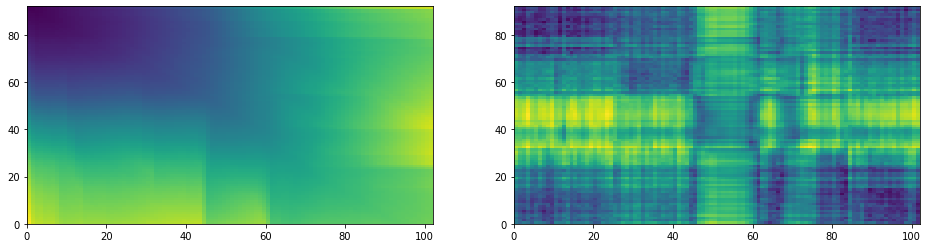

In [91]:
#Look at and compare woman and mans first repetition of digit 7
#TODO add path to dtw and show some nice plots comparing two samples
woman_7_a = data[id_seven[2]]
man_7_a = data[id_seven[0]]

d, LD, AD, path = proto.dtw(man_7_a["lmfcc"],woman_7_a["lmfcc"])

fig, axs = plt.subplots(1,2,figsize=(16, 4))
axs[0].pcolormesh(AD)
#axs[0].plot(path[:,0],path[:,1])
axs[1].pcolormesh(LD)
#axs[1].plot(path[:,0],path[:,1])
#plt.show()


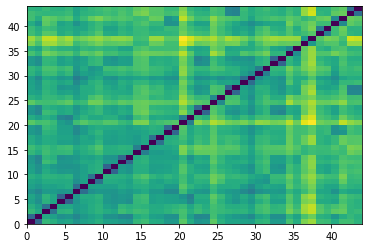

In [92]:
#--------
# D = np.zeros((len(data),len(data)))
# for i, datapt in enumerate(data):
#     for j, datapt_compare in enumerate(data):
#         d, LD, AD, path = proto.dtw(datapt["lmfcc"],datapt_compare["lmfcc"])
#         D[i,j] = d
#         #load info
#         if i == j:
#             print(i,j)
#             print(d)

# savetxt("D.csv",D,delimiter=",")
#-------
D = loadtxt("D.csv",delimiter=",")
#-------

plt.pcolormesh(D)
plt.show()

**Compare distances within the same digit and across different digits. Does the distance separate digits well even between different speakers?**
One sees above that the same sample of course generates 0 global distance. That's what reveals the diagonal appearnace. Along the diagonal there exists low global distances which refers to the second repetition of the same speaker. Although outside this 2x2 square the global distances vary quite a lot, even if it's the same digit but expressed by different speakers. 

## Hierarchical clustering

/var/folders/q9/fn0bq0g17g1_dkmkvbvcxll00000gn/T/ipykernel_20699/219877718.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


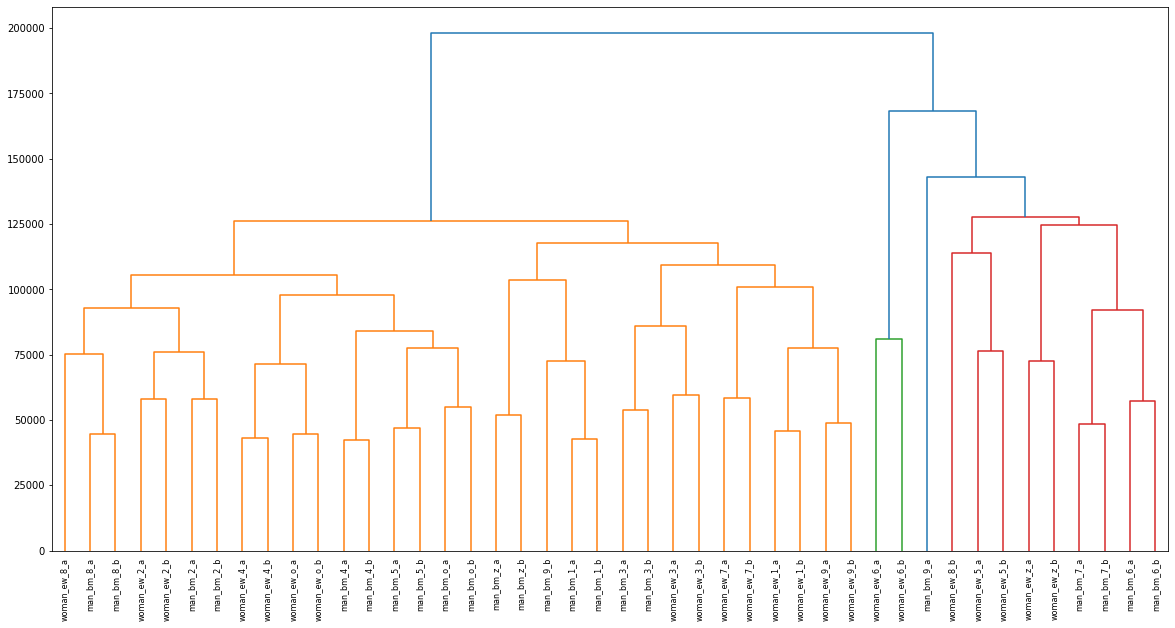

In [93]:
clustering = linkage(D,method="complete")
fig = plt.figure(figsize=(20,10))
tree = dendrogram(clustering,labels=tools.tidigit2labels(data))

Two samples that are the shortest euclidian distance from each other are linked. The two closesest to each other have the lowest height if the linkage/box.
When a linkage of two samples that already exist in a cluster happens the two clusters are linked. 